# Analysis of Lending Data and Loan Default Rate Prediction

## Team Members:

* Kaluvala Dheeraj - 15AG1A05A2
* P. Rahul Sharma  - 15AG1A05B4
* R. Tharun        - 15AG1A0590
* P. Architha      - 15AG1A05B6

In [30]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

<p>
<span style="color:blue">
> Importing data of Lending club for the years 2017-19
</span>
</p>

In [31]:
Data17_18 = pd.read_csv('LoanStats_2017_18.csv',low_memory=False,skiprows=1)
Data19    = pd.read_csv('LoanStats_2019.csv',low_memory=False,skiprows=1)

## Data Cleaning

<p>
<span style="color:blue">
> Merged datasets of 2017-19 <br>
> Removed all empty columns ( these are the columns with personal data of the borrowers. These are not disclosed by the company. so we dropped them)<br>
> Target variable(Borrower is a Loan defaulter) - encoded to 0 or 1<br>
</span>
</p>

In [32]:
dataset = pd.concat([Data17_18,Data19]) #merging 2017 to 2019 datasets
dataset = dataset.iloc[:,2:111]          #removing empty columns
empty_cols = [i for i in range(45,72)]   #more empty columns
dataset = dataset.drop(dataset.columns[empty_cols],axis=1) #droping empty coloumns
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [33]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (409628, 82)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,12000.0,12000.0,12000.0,36 months,6.62%,368.45,A,A2,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,105000.0,Not Verified,Dec-2013,0,n,NaN,NaN,debt_consolidation,UNIVERSAL CARD,060xx,CT,14.05,0.0,Mar-1994,1.0,43.0,NaN,12.0,0.0,13168.0,21.6%,22.0,w,0.0,0.0,13263.954639,...,4.0,26765.0,39432.0,25.0,0.0,0.0,146.0,237.0,20.0,3.0,4.0,20.0,NaN,3.0,43.0,0.0,2.0,2.0,5.0,5.0,9.0,8.0,9.0,2.0,12.0,0.0,0.0,0.0,2.0,95.5,0.0,0.0,0.0,333044.0,42603.0,52600.0,42769.0
1,28000.0,28000.0,28000.0,36 months,7.62%,872.52,A,A3,Area Sales Manager,5 years,MORTGAGE,325000.0,Source Verified,Dec-2013,0,n,NaN,NaN,debt_consolidation,Pay off other Installment loan,945xx,CA,18.55,0.0,Nov-1994,1.0,NaN,NaN,15.0,0.0,29581.0,54.6%,31.0,w,0.0,0.0,29150.980000,...,6.0,53306.0,13901.0,67.1,0.0,0.0,125.0,229.0,5.0,2.0,5.0,5.0,NaN,3.0,NaN,0.0,4.0,5.0,6.0,8.0,11.0,9.0,15.0,5.0,15.0,0.0,0.0,0.0,5.0,100.0,16.7,0.0,0.0,850886.0,199739.0,42200.0,196686.0
2,27050.0,27050.0,27050.0,36 months,10.99%,885.46,B,B2,Team Leadern Customer Ops & Systems,10+ years,OWN,55000.0,Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,Debt Consolidation,481xx,MI,22.87,0.0,Oct-1986,0.0,NaN,NaN,14.0,0.0,36638.0,61.2%,27.0,w,0.0,0.0,31752.530000,...,3.0,9570.0,16473.0,53.9,0.0,0.0,117.0,326.0,16.0,6.0,4.0,16.0,NaN,8.0,NaN,0.0,2.0,4.0,4.0,8.0,8.0,10.0,15.0,4.0,14.0,0.0,0.0,0.0,1.0,100.0,25.0,0.0,0.0,138554.0,70186.0,35700.0,33054.0


In [34]:
dataset=Dataset_withBoolTarget.dropna(thresh = 409628,axis=1) # it is minimum number of non-NA values
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (409628, 40)


<p>
<span style="color:blue">
> some more columns were dropped in the below cell. some of them are not related to our target variable and some of them are redundant. <br>
</span>
</p>

In [35]:
del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
"pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
"chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1,errors = 'ignore') 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (409628, 25)


<p>
<span style="color:blue">
> After indepth research about these rest 25 features, We selected ~7 relevant features using correlation matrix values. After few cells (in this ipython notebook), we used "RFE (Recursive Feature Elimination)" and " PCA(Principle Component Analysis)" do the actual feature selection.<br>
</span>
</p>

In [36]:
features = ['funded_amnt','annual_inc',"last_pymnt_amnt", "pub_rec", "int_rate", "open_acc",'loan_status']
#'sub_grade' #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #19 features with target var
Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, converting to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (409628, 7)


## Data Transformation


In [37]:
print("Current shape of dataset :",Final_data.shape)
Final_data.tail()

Current shape of dataset : (409628, 7)


,funded_amnt,annual_inc,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
409623,18400.0,110000.0,7394.95,0.0,14.47,18.0,0
409624,22000.0,78000.0,17.50,1.0,19.97,18.0,1
409625,2000.0,83000.0,1500.68,0.0,7.90,21.0,0
409626,20700.0,46000.0,4856.22,0.0,16.99,18.0,0
409627,10000.0,46000.0,367.20,0.0,19.20,6.0,0


## Filling Missing values and Feature scaling 


<p>
<span style="color:blue">
> We have some important features which have some missing values. We filled those missing values with the mean of the column. <br>
> We scaled the all the features here by using standard scaler. <br>
> We sampled our dataset here after infering from the learning curve plotted.
</span>
</p>

In [38]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (409628, 7)


In [39]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0    338906
1     70722
Name: loan_status, dtype: int64

In [40]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=10000)
subset_of_loanstatus_1 = loanstatus_1.sample(n=10000)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (20000, 7)


,funded_amnt,annual_inc,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,0.364997,-0.492074,-0.637631,-0.323447,-0.442309,-0.470149,1
1,-0.659958,-0.437443,-0.682007,-0.323447,0.090664,-0.871521,1
2,-1.204182,-0.157764,-0.707104,1.568445,0.240990,0.332595,0
3,-0.783920,-0.903575,-0.685269,-0.323447,0.981232,-1.072207,0
4,-1.022774,-0.735768,-0.702483,-0.323447,-1.695026,-0.068777,1


In [41]:
data_clean.head()

,funded_amnt,annual_inc,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,0.364997,-0.492074,-0.637631,-0.323447,-0.442309,-0.470149,1
1,-0.659958,-0.437443,-0.682007,-0.323447,0.090664,-0.871521,1
2,-1.204182,-0.157764,-0.707104,1.568445,0.240990,0.332595,0
3,-0.783920,-0.903575,-0.685269,-0.323447,0.981232,-1.072207,0
4,-1.022774,-0.735768,-0.702483,-0.323447,-1.695026,-0.068777,1


<p>
<span style="color:blue">
Below are correlation values between the features finally selected.
</span>
</p>

In [42]:
data_clean.corr()

,funded_amnt,annual_inc,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
funded_amnt,1.000000,0.426768,0.322650,-0.081693,0.183286,0.201675,0.067231
annual_inc,0.426768,1.000000,0.201161,-0.004452,-0.055421,0.173040,-0.083378
last_pymnt_amnt,0.322650,0.201161,1.000000,-0.031413,-0.012365,0.061421,-0.467207
pub_rec,-0.081693,-0.004452,-0.031413,1.000000,0.048396,-0.025659,0.020336
int_rate,0.183286,-0.055421,-0.012365,0.048396,1.000000,-0.002985,0.298659
open_acc,0.201675,0.173040,0.061421,-0.025659,-0.002985,1.000000,0.031179
loan_status,0.067231,-0.083378,-0.467207,0.020336,0.298659,0.031179,1.000000


## Learning Curve

<p>
<span style="color:blue">
> This learning curve clearly shows that our models are not learning anything after given samples. So we randomly sampled our dataset and used only 20,000 samples of our dataset.<br>
> Note: In the plot, only ~16000 samples are shown because it is a plot for training set.
</span>
</p>

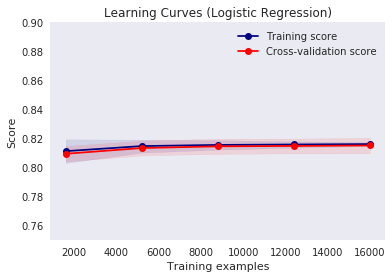

In [43]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="navy")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="red")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="navy",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="red",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 0.90), cv=cv, n_jobs=4)
plt.show()

## ROC Curve plot function

<p>
<span style="color:blue">
This is a callable ROC curve plot function. We have used this function to plot ROC Curve for all the models. We have used Seaborn package.
</span>
</p>

In [44]:
import seaborn as sns
sns.set( font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred,truth1,pred1, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    fpr1, tpr1, _ = metrics.roc_curve(truth1,pred1)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc1 = metrics.auc(fpr1,tpr1)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= 'darkorange',lw=lw, label= lab +'(TestAUC = %0.2f)' % roc_auc)
    plt.plot(fpr1,tpr1, color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

## Confusion Matrix Viz function

<p>
<span style="color:blue">
This is a callable Confusion Matrix Visualization function. We have used this function to visualize True positives, True Negatives, False Positives and False Negatives for all the models.
</span>
</p>

In [45]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

###  Feature Selection using RFE (Recursive Feature Elimination) 

In [47]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(clf_LR, 10)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# From above line of code, i have taken data_clean.iloc[:,:-1] intsead of taking in it X.. and data_clean.iloc[:,-1] instead of taking in it y.. values
# summarize the selection of the attributes
print(rfe.support_) #Shows True or false
print(rfe.ranking_) # If true prints 1 and if false prints 0

[ True  True  True  True  True  True]
[1 1 1 1 1 1]


In [48]:
#PCA (Principal Component Analysis)
from sklearn.decomposition import PCA 
pca = PCA(n_components=6, whiten=True) # We have taken our train 6 features as components in the PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [0.28904163 0.19910805 0.16791589 0.16114447 0.10551517 0.07727479]


In [49]:
features = ["funded_amnt", "annual_inc", "last_pymnt_amnt", "pub_rec", "int_rate", "open_acc",
            "loan_status"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(16000, 6)
(20000, 7)


In [50]:
dataViz = data_clean
corr = dataViz.corr()
corr

,funded_amnt,annual_inc,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
funded_amnt,1.000000,0.426768,0.322650,-0.081693,0.183286,0.201675,0.067231
annual_inc,0.426768,1.000000,0.201161,-0.004452,-0.055421,0.173040,-0.083378
last_pymnt_amnt,0.322650,0.201161,1.000000,-0.031413,-0.012365,0.061421,-0.467207
pub_rec,-0.081693,-0.004452,-0.031413,1.000000,0.048396,-0.025659,0.020336
int_rate,0.183286,-0.055421,-0.012365,0.048396,1.000000,-0.002985,0.298659
open_acc,0.201675,0.173040,0.061421,-0.025659,-0.002985,1.000000,0.031179
loan_status,0.067231,-0.083378,-0.467207,0.020336,0.298659,0.031179,1.000000


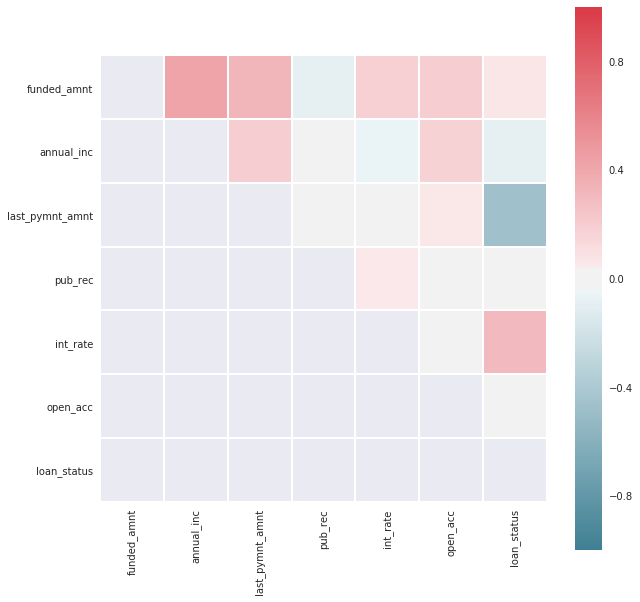

In [51]:
import warnings
warnings.filterwarnings('ignore')
#dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
#corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

# Models


## Random Forest with randomized Search

<p>
<span style="color:blue">
Random forest when implemented with randomized search we got the best accuracies and minimum false negatives(predicting borowwer will not default eventhough he will. This might impact on the credibility of the company). We used the randomized search to find the best hyper paramters for the model.
</span>
</p>

In [52]:
from sklearn.grid_search import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=3, scoring='roc_auc', n_iter=len(maxFeatures), random_state=10) ##
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
mean_scores = [result.mean_validation_score for result in rand.grid_scores_]
print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

Best Accuracy = 0.8863446234065517
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [53]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredict_train = randomForest.predict(X_train)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfPredictproba_train = randomForest.predict_proba(X_train)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)
print(roc_score)

0.8075
0.8078842739616414


## Feature Importance

Text(0,0.5,'Normalized Gini Importance')

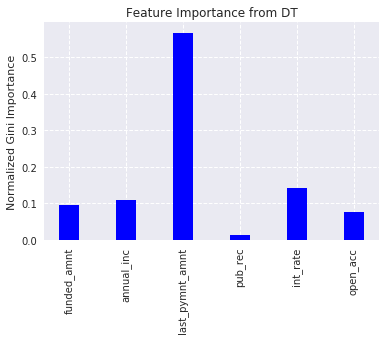

In [54]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color='blue')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

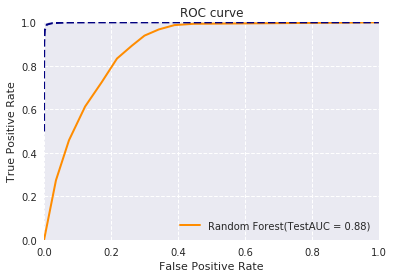

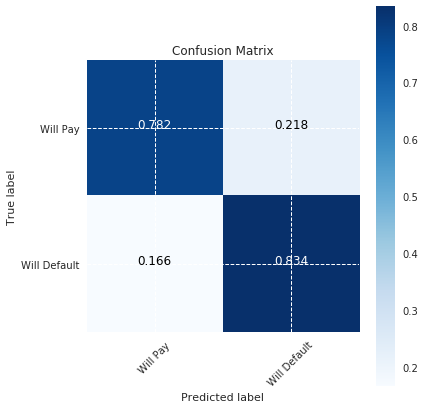

In [55]:
plotAUC(y_test,rfPredictproba,y_train,rfPredictproba_train, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

## Logistic Regression with Grid Search


<p>
<span style="color:blue">
When we implemented Logistic Regression with grid search we got the best accuracies and minimum false negatives.Then, We used the randomized search to find the best hyper paramters for the model.
</span>
</p>

In [56]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=5, scoring='roc_auc')
    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    grid.fit(X,y)
    mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    return mean_scores,grid.best_score_,grid.best_estimator_
logreg = linear_model.LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)

Best accuracy is 0.886243
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Logistic regression accuracy is  0.814 ------Logistic regression AUC score is 0.815743542297017


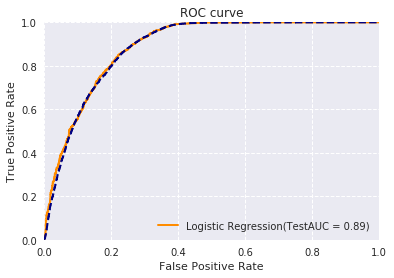

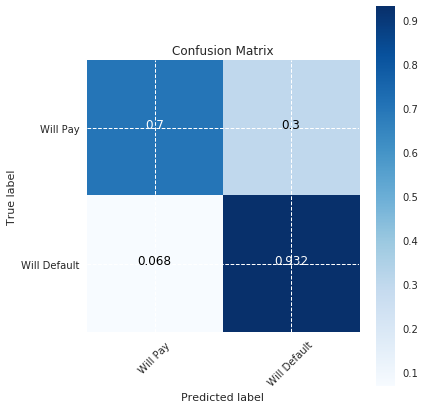

In [57]:
clf_LR = linear_model.LogisticRegression(C=Best_classifier.C)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_train = clf_LR.predict_proba(X_train)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
LR_roc=metrics.roc_auc_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy,"------Logistic regression AUC score is",LR_roc)
#plotAUC(y_test,rfPredictproba,y_train,rfPredictproba_train, 'Random Forest')
plotAUC(y_test,LR_Predict,y_train,LR_Predict_train,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

## Support Vector Machines(SVM) with Grid Search CV

<p>
<span style="color:blue">
SVM (Support Vector Machines) when implemented with grid search, we got the best accuracies and minimum false negatives. We used the Grid search to find the best hyper paramters for the model.<br> Later we used this value to find the predictions and plot the ROC curve.
</span>
</p>

In [58]:
from sklearn.grid_search import GridSearchCV    ## takes too much time to run this cell.
clf_svm = svm.SVC(kernel = "rbf")
powers = range(0,5)
cs = [10**i for i in powers]
param_grid = dict(C=cs)
grid = GridSearchCV(clf_svm, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train,y_train)
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'C': 1}
---------------
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVM accuracy is  0.807 SVM AUC Score 0.8090120277062338


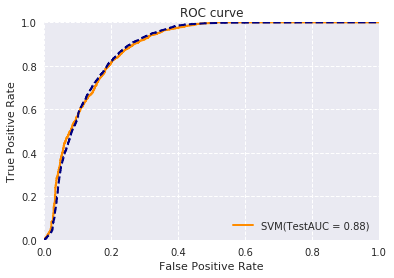

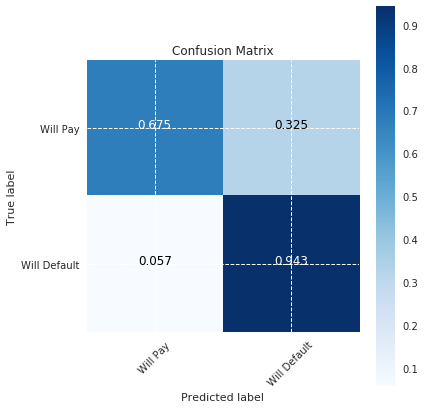

In [59]:
clf = svm.SVC(kernel = "rbf", C=grid.best_estimator_.C)
clf.fit(X_train,y_train)
predictions_svm = clf.predict(X_test)
predictproba_svm = clf.decision_function(X_test)
predictproba_svm_train = clf.decision_function(X_train)
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
SVM_roc=metrics.roc_auc_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy, "SVM AUC Score" , SVM_roc)
plotAUC(y_test,predictproba_svm,y_train,predictproba_svm_train,'SVM')
#plotAUC(y_test,rfPredictproba, 'Random Forest')
#plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

## K Nearest Neighbors(KNN) with Grid Search CV

<p>
<span style="color:blue">
KNN (K Nearest Neighbors) when implemented with grid search, we got the best accuracies and minimum false negatives. 
We used the Grid search to find the best hyper paramters for the model.Later we used this value to find the predictions and plot the ROC curve.
</span>
</p>

In [60]:
#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1
from sklearn.grid_search import GridSearchCV    ## takes too much time to run this cell.
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train,y_train)
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'n_neighbors': 40}
---------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=40, p=2,
           weights='uniform')


Optimal N-neighbor 40
KNN accuracy is  0.77375 --- KNN AUC score is 0.7754057162861644


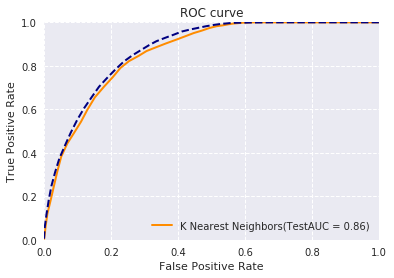

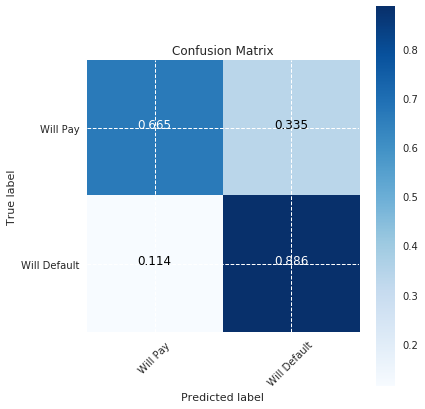

In [61]:
print("Optimal N-neighbor",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
knn_predictproba = clf_knn_final.predict_proba(X_test)[:,1]
knn_predictproba_train = clf_knn_final.predict_proba(X_train)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
KNN_roc=metrics.roc_auc_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc,"--- KNN AUC score is",KNN_roc)
#plotAUC(y_test,rfPredictproba, 'Random Forest')
#plotAUC(y_test,LR_Predict,'Logistic Regression')
#plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,y_train,knn_predictproba_train,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

## Bagging for Classification

<p>
<span style="color:blue">
We have tried following ensemble algorithms to check if they can give better results. <br>
Bagging : <br>
> Create many random sub-samples of our dataset with replacement. <br>
> Train a CART(Classfication and Regression Trees) model on each sample.   <br>
> Given a new dataset, calculate the average prediction from each model <br>
</span>
</p>  

In [62]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
num_trees = 100
model = BaggingClassifier(base_estimator=randomForest, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X,y, cv=kfold)
print(results.mean())

0.8255500000000001


In [63]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
#num_trees = 100
model = BaggingClassifier(base_estimator=clf_LR, random_state=seed)
results = model_selection.cross_val_score(model, X,y, cv=kfold)
print(results.mean())

0.8170999999999999


## Ada Boost classifier

<p>
<span style="color:blue">
Ada Boost is one of the most commonly used ensemble algorithms. <br>
It works by weighting instances in the dataset by how easy or difficult they are to classify, allowing the algorithm to pay or less attention to them in the construction of subsequent models. <br>
</span>
</p>  

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(Ada_clf,X,y)
scores.mean()

0.8197501963753665

## Multi-Layer Perceptron Classifier

<p>
<span style="color:blue">
A multilayer perceptron (MLP) is a feedforward artificial neural network. An MLP consists of atleast three layers of nodes. MLP utilizes a supervised learning technique called backpropagation for training.Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable. We got our highest accuracy for MLP classifier(little higher than Logistic Regression with Grid Search CV).
</span>
</p>

Accuracy score is 0.818
Roc_AUC score is 0.8194968867995298


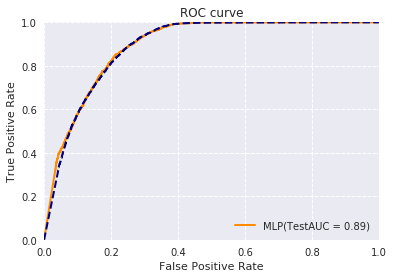

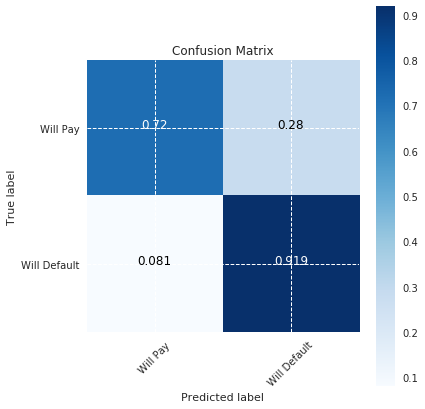

In [65]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf_NN.fit(X_train,y_train)     
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
predictproba_NN_train = clf_NN.predict_proba(X_train)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
NN_roc=metrics.roc_auc_score(y_test,predict_NN)
print('Accuracy score is',NNAccuracy)
print('Roc_AUC score is',NN_roc)
#plotAUC(y_test,rfPredictproba, 'Random Forest')
#plotAUC(y_test,LR_Predict,'Logistic Regression')
#plotAUC(y_test,predictproba_svm, 'SVM')
#plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,y_train,predictproba_NN_train,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.show()

## Precision,recall,F1score for all models

In [66]:
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("SVM",classification_report(y_test, predictions_svm, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))
print("MLP",classification_report(y_test, predict_NN, target_names=None))

RF              precision    recall  f1-score   support

          0       0.83      0.78      0.80      2030
          1       0.79      0.83      0.81      1970

avg / total       0.81      0.81      0.81      4000

SVM              precision    recall  f1-score   support

          0       0.92      0.67      0.78      2030
          1       0.74      0.94      0.83      1970

avg / total       0.83      0.81      0.80      4000

LR              precision    recall  f1-score   support

          0       0.91      0.70      0.79      2030
          1       0.75      0.93      0.83      1970

avg / total       0.83      0.81      0.81      4000

KNN              precision    recall  f1-score   support

          0       0.86      0.67      0.75      2030
          1       0.72      0.89      0.79      1970

avg / total       0.79      0.77      0.77      4000

MLP              precision    recall  f1-score   support

          0       0.90      0.72      0.80      2030
          1    

## Behaviour of models with different sample sizes of dataset

<p>
<span style="color:blue">
Here we have plotted ROC_AUC_Score for different sample sizes.
</span>
</p>

In [73]:
def modBootstrapper(train, test, nruns, sampsize, model, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (model == "LR"):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Logistic regression
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        elif (model == "SVM"):
            svm_i = svm.SVC(kernel='rbf', C = c) 
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        elif (model == "RF"):
            RF_i = RandomForestClassifier(bootstrap=True,criterion = "gini")
            RF_i.fit(train_samp.drop(target,1), train_samp[target])
            p = RF_i.predict_proba(X_test)[:,1]
        elif (model == "KNN"):
            knn_i = KNeighborsClassifier(n_neighbors= 30) #taking the the best from the above cell and using it to find predictions
            knn_i.fit(train_samp.drop(target,1), train_samp[target])
            p = knn_i.predict_proba(X_test)[:,1]
            
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

In [74]:
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping
SampleSizes = [250,1000,1500,2000,2750,3750,4500,5200,6500,7000,8000,8500,9000,10000,11000,12000,15000,18000,20000] #various samples of Dataset
LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
RF_means = []
RF_stderr = []
KNN_means = []
KNN_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 25, n, "LR", 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 25, n,"SVM", 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    mean3, err3 = modBootstrapper(bs_train, bs_test, 25, n,"RF", 0.1)# collecting means and stderrs for SVM model
    RF_means.append(mean3)
    RF_stderr.append(err3)
    mean4, err4 = modBootstrapper(bs_train, bs_test, 25, n,"KNN", 0.1)# collecting means and stderrs for SVM model
    KNN_means.append(mean4)
    KNN_stderr.append(err4)
    print(n)  

250
1000
1500
2000
2750
3750
4500
5200
6500
7000
8000
8500
9000
10000
11000
12000
15000
18000
20000


Text(0,0.5,'roc_auc_score')

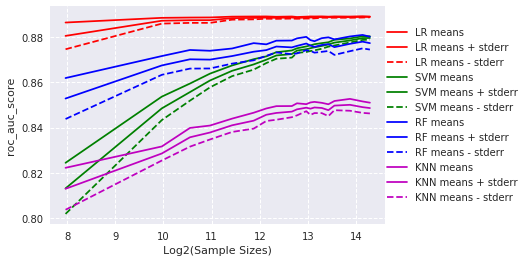

In [75]:
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-', label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means - stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.plot(np.log2(SampleSizes), RF_means, 'b', label = 'RF means')
plt.plot(np.log2(SampleSizes), RF_means + np.array(RF_stderr), 'b+-', label = 'RF means + stderr')
plt.plot(np.log2(SampleSizes), RF_means - np.array(RF_stderr), 'b--', label = 'RF means - stderr')

plt.plot(np.log2(SampleSizes), KNN_means, 'm', label = 'KNN means')
plt.plot(np.log2(SampleSizes), KNN_means + np.array(KNN_stderr), 'm+-', label = 'KNN means + stderr')
plt.plot(np.log2(SampleSizes), KNN_means - np.array(KNN_stderr), 'm--', label = 'KNN means - stderr')

plt.legend(bbox_to_anchor=(1.20, 0.5),loc = 10)
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')

## Conclussion :    

|-------------------------------------------|<br>
| Model----------------------Accuracy|<br>
|-------------------------------------------|<br>
|Random Forest ---------------0.80|<br>
|-------------------------------------------|<br>
|Logistic regression ---------0.812 |<br>
|-------------------------------------------|<br>
| Svm -----------------------------0.80 |<br>
|-------------------------------------------|<br>
|Knn ------------------------------0.77 |<br>
|-------------------------------------------|<br>
|Bagging using RF ------------0.82|<br>
|-------------------------------------------|<br>
|Bagging using Log-Regr----0.81 |<br>
|-------------------------------------------|<br>
|Ada Boosting ------------------0.81 |<br>
|-------------------------------------------|<br>
|Multi-layer perceptron ------0.81 |<br>
|-------------------------------------------|<br>
<p>
<span style="color:green">
    Our Project is about Lending club data anaysis as well as of same Data rate prediction., we have applied advanced as well as regular algorithms in this project to see model accuracies ,confusion matrices , learning curve and also roc-auc curve using tpr,fpr. <br>
    Although all the algorithms except KNN have almost same accuracy, their False Negative rates differ which is our main evaluation metric. From the confusion matrices, we can infer that Support vector machine model had the least False Negative rate (FNR)
    </span>
    </p>
